# Particle Trajectory

leapfrog following Flip's template from: https://github.com/Physics177-2018/Lecture_08/blob/master/Lecture%208%2C%20leapfrog.ipynb

## TO DO

** Background ** 
 
The algorithm for the leapfrog method requires that we input the time of flight beforehand. This is reasonably okay since the only trajectories we care about will be mostly straight, and neutrinos are moving at essentially the speed of light, so their time of flight will be slightly over `lightTime`. The catch is the method of controling the loop is now time instead of distance. This means that our neutrino will travel for however long we tell it to, which doesn't necessarily stop at Earth. 

** Resolution ** (Option 2 implemented 7.22.21 9:51)

1. We can keep the algorithm the same, by keeping the loop control scheme to time. This will mean that the neutrino will actually overshoot the Earth and we need to manually identify where the Earth is in the position and velocity vectors.

2. We might be able to implement a `break` statement in the loop that tells the loop to end when `dist == EarthDist`. To do this, we would need to intentionally overshoot earth, but also decrease `dt` enough to give a good resolution for the part of the trajectory we care about. 

3. There is some double check about the time of flight that we need to implement but i need to think harder about that. The actul time of flight (starting from the actual initial positon) should always be.....idk it could go either way compared to `lightTime`

** Comments ** (updated 7.24.21)

1. I think we are good with option 2. The actual times of flight (for the truncated coputation) are all less then `lightTime` and the velocity at each step is explicitly conserved. 

** Background **
We on Earth only detect the Neutrinos that hit the Earth. As far as I can tell, there isn't a way of knowing which initial conditions yield neutrinos that will actually hit earth, since their trajectory depends on a spatially dependent magnetic field. In the coordinate system we have chosen, the sun is spinning about the z-axis, so the solar plane is x-y plane (z=0). This means that the only trajectories that hit earth have z=0 at the end. I don't know how to check this other than trial and error for a bunch of trajectories.

## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from random import random

import plotly
import plotly.offline as offline
offline.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls


%matplotlib inline 

print ('Complete')

Complete


## Function Definitions

In [2]:
rDot = 0.00465047 # in au
lightTime = 1 # in Au/C

def rFunction(x,y,z):
    ''' 
    Returns the spherical coordinate "r" given x,y,z.
    '''
    return np.sqrt(x**2 + y**2 + z**2)

def thetaFunction(x,y,z):
    ''' 
    Returns the spherical coordinate "theta" given x,y,z.
    '''
    return np.arctan2(np.sqrt(x**2 + y**2),z) 

def phiFunction(x,y,z):
    ''' 
    Returns the spherical coordinate "phi" given x,y,z.
    '''
    return np.arctan2(y,x)

def sph2Cartesian(rVect):
    '''
    '''
    r = rVect[0]
    theta = rVect[1]
    phi = rVect[2]

    X = r*np.sin(theta)*np.cos(phi)
    Y = r*np.sin(theta)*np.sin(phi)
    Z = r*np.cos(theta)

    return [X,Y,Z]
    

def distance(x,y,z,x0,y0,z0):
    ''' 
    vect1 and vect2 must be in cartesian coordinates
    Returns the distance between vect1 and vect2
    '''
#     x,y,z = vect1[0],vect1[1],vect1[2]
#     x0,y0,z0 = vect2[0],vect2[1],vect2[2]
    return np.sqrt( (x-x0)**2 + (y-y0)**2 +(z-z0)**2 )


def km2au(num):
    return num*6.6846e-9

def sec2geVInv(num):
    return 1.52E24* num

def km2geVInv(num):
    return 5.06E18*num

def geVInv2km(num):
    return 5.06E18**-1 * num

def geVInv2au(num):
    return num*5.06*10**13 * 10**-5 *6.6846*10**-9

def au2km(num):
    return num*1.496e+8

def auOverc2min(num):
    return 8.3167464*num 


def cosBeta(vec1,vec2):
    ''' 
    Returns cos of the angle between 3-vectors vec1 and vec2
    '''
    x1 = vec1[0]
    y1 = vec1[1]
    z1 = vec1[2]
    x2 = vec2[0]
    y2 = vec2[1]
    z2 = vec2[2]

    numerator = (x1*x2) + (y1*y2) + (z1*z2) 
    denominator = np.sqrt( x1**2 +y1**2 +z1**2) * np.sqrt(x2**2 +y2**2 +z2**2 )
    return (numerator/denominator)


def posAvg(r1,r2):
    ''' 
    Averages two position 3-vectors
    r1 is the initial position 3-vector
    r2 is the final position 3-vector
    '''
    x1 = r1[0]
    y1 = r1[1]
    z1 = r1[2]
    x2 = r2[0]
    y2 = r2[1]
    z2 = r2[2]

    xavg = (x2+x1)/2
    yavg = (y2+y1)/2
    zavg = (z2+z1)/2

    return [xavg,yavg,zavg]


def velocityAvg(r1, r2):
    '''
    Newtonian estimate of the velocity vector between two locations.

    r1 and r2 are both position 3-vectors in cartesian

    returns the cartesian 3-velocity 

    eg: vAvgX = x1 + 1/2*(deltaX)
    '''
    x1 = r1[0]
    y1 = r1[1]
    z1 = r1[2]
    x2 = r2[0]
    y2 = r2[1]
    z2 = r2[2]

    deltavX = x2 - x1
    deltavY = y2 - y1
    deltavZ = z2 - z1

    vavgX = x1 + (1/2)*deltavX
    vavgY = y1 + (1/2)*deltavY
    vavgZ = z1 + (1/2)*deltavZ

    return [vavgX,vavgY,vavgZ]


def conditionSph2Car(sphCon,row):
    '''
    vel and pos are in spherical coordinates 
    '''
    r,theta,phi = sphCon[0],sphCon[1],sphCon[2]
    vr,vtheta,vphi = sphCon[3],sphCon[4],sphCon[5]

    x = r*np.sin(theta)*np.cos(phi)
    y = r*np.sin(theta)*np.sin(phi)
    z = r*np.cos(theta)

    vx = vr*np.sin(theta)*np.cos(phi)
    vy = vr*np.sin(theta)*np.sin(phi)
    vz = vr*np.cos(theta)

    error = 0.000000001
    assert r-error*r <= np.sqrt(x**2 + y**2 + z**2) <= r+error*r, \
    "Row {0}: Cartesian <-> spherical distance larger than {1}% incorrect".format(row,100*error)
    
    return [x,y,z,vx,vy,vz]


def Bfield(x,y,z):
    '''
    Returns cartesian components of the B-field at location x,y,z
    
    x,y,z must be in cartesian coordinates measured in Au'''
    
#  T = 1 kg⋅s−2⋅A−1 = N s / C m = kg / C s 
#    = [mass] / [charge] [time]

    # 3.3 in nT
    Br     = 0
    Btheta = 3.3e-9/np.sqrt(2) * 1/rFunction(x,y,z)
#     Bphi   = 3.3e-9/np.sqrt(2) * 1/rFunction(x,y,z)
    Bphi = 0

    # Spherical unit vector decompositions
    # Schematically, we decompose rhat = Axhat + Byhat + Czhat and read off the ABC from wiki
    # The arguments of the ABCs are the cartesian location where we are evaluating the B field
    def A(x,y,z):
        return x/np.sqrt(x**2 +y**2 +z**2)

    def B(x,y,z):
        return y/np.sqrt(x**2 +y**2 +z**2)

    def C(x,y,z):
        return z/np.sqrt(x**2 +y**2 +z**2)

    def D(x,y,z):
        return x*z / (np.sqrt(x**2 +y**2 +z**2) * np.sqrt(x**2+y**2))

    def E(x,y,z):
        return y*z / (np.sqrt(x**2 +y**2 +z**2) * np.sqrt(x**2+y**2))
        
    def F(x,y,z): 
        return -(x**2 + y**2) / (np.sqrt(x**2 +y**2 +z**2) * np.sqrt(x**2+y**2)) 

    def G(x,y,z):
        return -y / np.sqrt(x**2 + y**2)

    def H(x,y,z):
        return x / np.sqrt(x**2 + y**2)

    def I(x,y,z):
        return 0

#     Bx = Br * A(x,y,z) + Btheta * D(x,y,z) + Bphi * G(x,y,z)
#     By = Br * B(x,y,z) + Btheta * E(x,y,z) + Bphi * H(x,y,z)
#     Bz = Br * C(x,y,z) + Btheta * F(x,y,z) + Bphi * I(x,y,z)

    Bx, By, Bz = 0,0,1

    return (Bx,By,Bz)


def acceleration_normed(vel, pos):
    '''
    Returns acceleration of a unit charge of unit mass with velocity vel at position pos
    '''
    x = pos[0]
    y = pos[1]
    z = pos[2]
    return np.cross(vel,Bfield(x,y,z)) 


def step(pos, vel, acc, dt, q_by_m):
    '''Computes the new position given the old position, velocity, acceleration, and dt
    using the simplest differential equation solver.
    '''
    
    x,y,z = pos[0],pos[1],pos[2]
    

    return next_pos, next_vel, next_acc


def trajectorySolver(initialConditions, q_e, m_MeV, dt):
    '''
    xi = gB-L/q_e

    Inputs:
        initialConditions: array of [r0,v0] in cartesian
        q : the electric charge in units of "e"
        m : the mass/energy of the particle in kg.
        dt: the time increment between each step in Au/c

    Returns:
        trajectory: the 3-vector (x,y,z), the position of the neutrino at each step
        velocity  : the 3-vector (vX,vY,vZ), the velocity of the neutrino at each step
    '''
    r0 = initialConditions[0:3]
    v0 = initialConditions[3:6]

    assert ((r0[0] != 0) or (r0[1] !=0)), "X and Y initial positions cannot be simultaneously zero. See Jacobian tranformation in the definition of Bfield."
    q_coulombs  = q_e * 1.60217662E10-19  # units of Coulombs
    m_kg  = m_MeV / 5.6095861672249E+29 # units of kilograms
    
#     q_by_m  = q_coulombs/m_kg
    q_by_m  = 1

    # pos = np.array([r0[0],r0[1],r0[2]])
    # vel = np.array([v0[0],v0[1],v0[2]]) 
    pos = np.asarray(r0)
    vel = np.asarray(v0)

#     acc = q_by_m * acceleration_normed(vel, pos)

    xPoints=[] # record of x-values
    yPoints=[] # record of y-values
    zPoints=[] # record of z-values
    vxPoints=[] # record of x-velocities
    vyPoints=[] # record of y-velocities
    vzPoints=[] # record of z-velocities
    

    def dvdt(pos,vel,dt,q_by_m):
        x,y,z = pos[0],pos[1],pos[2]
        return q_by_m*np.cross(vel,Bfield(x,y,z))

    def dxdt(pos,vel,dt,q_by_m):
        return vel
    
    

    # Initialize half values
    x_half = pos[0] + 0.5*dt*dxdt(pos,vel,dt,q_by_m)[0]
    y_half = pos[1] + 0.5*dt*dxdt(pos,vel,dt,q_by_m)[1]
    z_half = pos[2] + 0.5*dt*dxdt(pos,vel,dt,q_by_m)[2]
    
    vx_half = vel[0] + 0.5*dt*dvdt(pos,vel,dt,q_by_m)[0]
    vy_half = vel[1] + 0.5*dt*dvdt(pos,vel,dt,q_by_m)[1]
    vz_half = vel[2] + 0.5*dt*dvdt(pos,vel,dt,q_by_m)[2]

    posHalf = [x_half,y_half,z_half]
    velHalf = [vx_half,vy_half,vz_half]
    
    
    distance = np.sqrt(pos[0]**2 + pos[1]**2 + pos[2]**2)
    earthDist = 1
    while distance < earthDist:
        # Append Points
        xPoints.append(pos[0])
        yPoints.append(pos[1])
        zPoints.append(pos[2])
        vxPoints.append(vel[0])
        vyPoints.append(vel[1])
        vzPoints.append(vel[2])
        
        # Leapfrog
        pos[0] += dt*dxdt(posHalf,velHalf,dt,q_by_m)[0]
        pos[1] += dt*dxdt(posHalf,velHalf,dt,q_by_m)[1]
        pos[2] += dt*dxdt(posHalf,velHalf,dt,q_by_m)[2]
        vel[0] += dt*dvdt(posHalf,velHalf,dt,q_by_m)[0]
        vel[1] += dt*dvdt(posHalf,velHalf,dt,q_by_m)[1]
        vel[2] += dt*dvdt(posHalf,velHalf,dt,q_by_m)[2]
        
        
        posHalf[0] += dt*dxdt(pos,vel,dt,q_by_m)[0]
        posHalf[1] += dt*dxdt(pos,vel,dt,q_by_m)[1]
        posHalf[2] += dt*dxdt(pos,vel,dt,q_by_m)[2]
        velHalf[0] += dt*dvdt(pos,vel,dt,q_by_m)[0]
        velHalf[1] += dt*dvdt(pos,vel,dt,q_by_m)[1]
        velHalf[2] += dt*dvdt(pos,vel,dt,q_by_m)[2]
    
        distance = np.sqrt(pos[0]**2 + pos[1]**2 + pos[2]**2)
    
    trajectory = [xPoints,yPoints,zPoints]
    velocity   = [vxPoints,vyPoints,vzPoints]

    trajTime = auOverc2min(len(trajectory[0])*dt)

#     assert(trajTime > auOverc2min(lightTime)), "Trajectory Time: {0} min. Neutrino is moving faster than light.".format(trajTime)
#     if (trajTime < auOverc2min(lightTime)):
#         print ('WARNING: neutrino moving faster than light. Change dt')
#         print ('Current dt: ',dt)
    if (len(trajectory[0]) <= 2):
        print ('WARNING: only two data points in the trajectory. Decrease dt')
        print ('Current dt: ',dt)

    return (trajectory,velocity)


def sphDF2CarDF(dataDFSph):
    columns = ['x','y','z','vx','vy','vz','L','cosBeta']
    dataDFCar = pd.DataFrame(columns=columns)
    
    for row in np.arange(0,dataDFSph.shape[0]):
        sphCon = np.asarray(dataDFSph.iloc[int(row)][:-2])
        
        L = dataDFSph.iloc[int(row)][-2]
        cosBeta = dataDFSph.iloc[int(row)][-1]
        
        carConPos = conditionSph2Car(sphCon,row)[0:3]
        carConVel = conditionSph2Car(sphCon,row)[3:6]

        x = carConPos[0]
        y = carConPos[1]
        z = carConPos[2]

        vx = carConVel[0]
        vy = carConVel[1]
        vz = carConVel[2]

        appendThis = ({'x':x,'y':y,'z':z,'vx':vx,'vy':vy,'vz':vz,'L':L,'cosBeta':cosBeta})
        dataDFCar = dataDFCar.append(appendThis,ignore_index=True)
    return dataDFCar


def lossFunction(trajectorySolverOutput):
    '''
    This breaks for vmax 3 digits and larger
    vmax = 99 is fine, but vmax = 100 breaks this function
    '''
    positions = trajectorySolverOutput[0]
    zlocations = positions[2]
    zLoss = (zlocations[-1] + zlocations[-2]) * 0.5
    return zLoss


def endingAngle(trajectorySolverOutput):
    positions   = trajectorySolverOutput[0]
    velocities  = trajectorySolverOutput[1]
    x,y,z       = positions[0],positions[1],positions[2]
    vx,vy,vz    = velocities[0],velocities[1],velocities[2]
    lastPos     = [x[-1],y[-1],z[-1]]
    nextlastPos = [x[-2],y[-2],z[-2]]
    avgPos      = np.asarray(posAvg(nextlastPos,lastPos))
    lastVel     = [vx[-1],vy[-1],vz[-1]]
    nextlastVel = [vx[-2],vy[-2],vz[-2]]
    avgVel      = np.asarray(velocityAvg(lastVel,nextlastVel))
        
    return cosBeta(avgVel,avgPos)


def computeLossAndBeta(dataDFSph,q,m,dt):
    for row in np.arange(0,(dataDFSph.shape[0])):
        ICSph = np.asarray(dataDFSph.iloc[row][:-2])
        ICCar = conditionSph2Car(ICSph,row)
        output = trajectorySolver(ICCar,q,m,dt)
        
        loss = lossFunction(output)
        cosBeta = endingAngle(output)

        dataDFSph.iloc[row]['L'] = loss
        dataDFSph.iloc[row]['cosBeta'] = cosBeta
    return dataDFSph


print ('Complete')

Complete


## Single Trajectory

In [3]:
r0 = [rDot/2,0,0] # in Au
v0 = [1,0,0]              # dimensionless
m_MeV = 100                # MeV
q_e = 1                # electron charge
dt_au_c = 0.01            # in Au/c

initialCondition = np.concatenate((r0,v0))

output = trajectorySolver(initialCondition,q_e,m_MeV,dt_au_c)
trajectory = output[0]
timeOfFlight = auOverc2min(dt_au_c)*len(trajectory[0])

print ('1.0 Au/c in Min     :', auOverc2min(1.0))
print ('Time of Flight [min]:', timeOfFlight)
print ('LightTime [min]     :', auOverc2min(lightTime))
print ('CosBeta             :', endingAngle(output))

print ('Complete')

1.0 Au/c in Min     : 8.3167464
Time of Flight [min]: 8.3167464
LightTime [min]     : 8.3167464
CosBeta             : 1.0000000000000002
Complete


### MatPlotLib

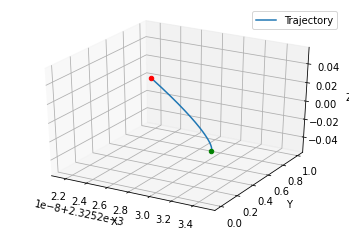

In [56]:
position = output[0]

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot(position[0], position[1], position[2], label='Trajectory')
ax.scatter(position[0][0],position[1][0],position[2][0], color = 'green')
ax.scatter(position[0][-1],position[1][-1],position[2][-1], color = 'red')
ax.legend()
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()

### Plotly

In [73]:
x = trajectory[0]
y = trajectory[1]
z = trajectory[2]
trace = go.Scatter3d(
    x=x,
    y=y,
    z=z,
    mode = 'markers',
    marker=dict(
        size=2,
        color = x,
        colorscale='Viridis'
    )
)
# layout = go.Layout(
# title = "Distance"),
# scene = dict(
#     xaxis = dict(title = 'X Location [au]'),
#     yaxis = dict(title = 'Y Location [au]'),
#     zaxis = dict(title = 'Z Location [au]'),
# )
# )

data = [trace]
fig = go.Figure(data=data)
offline.iplot(fig, filename='simple-3d-scatter')


# Hitting the Sun

The goal of this section is to determine which "patch" of neutrinos from the sun actually hits the Earth. We have no way of knowing this apriori, so we do take a simple approach.

1. Generate a set of random initial conditions over the surface of a sphere, with given velocities betwee 10-100 MeV.
2. Evolve all of the trajectories
3. For each trajectory, compute the Loss, $L \equiv z_{avg}-0$. $z_{avg}$ is the z-location of the neutrino at the location of Earth, which we approximate as the averate location between the last and second to last data points.
4. Find *the* single condition that minimizes the Loss. This is the trajectory that got the closest to Earth.
5. Generate a new set of initial conditions centered around that initial condition with a 1% deviation in $\theta$ and $phi$.

## Initial Conditions

### Generate Initial Condition Dataframe

In [3]:
velNum       = 25 # Number of velocities between vSlow and vFast
numPositions = 25

vSlow = 1
vFast = 99
vels = np.linspace(vSlow,vFast,velNum)
rHalf = rDot/2
positionRange = np.arange(0,numPositions)


columns = ['r','theta','phi','vr','vTheta','vPhi','L','cosBeta']
dataDFSph = pd.DataFrame(columns=columns)

# print (random())

for vr in vels:
    v1 = [vr,0,0]

    for i in positionRange:
        
        randPhi = random()*2*np.pi
        randTheta = random()*np.pi

        p1 = [rHalf,randTheta,randPhi]

        initialCondition = np.concatenate((p1,v1))
        
        r      = p1[0]
        theta  = p1[1]
        phi    = p1[2]
        vr     = v1[0]
        vtheta = v1[1]
        vphi   = v1[2]

        appendThis = ({'r':r,'theta':theta,'phi':phi,'vr':vr,'vTheta':vtheta,'vPhi':vphi,'L':0,'cosBeta':0})
        dataDFSph = dataDFSph.append(appendThis,ignore_index=True)

print ('{0} Initial Conditions'.format(dataDFSph.shape[0]))
# print (np.asarray(dataDF.iloc[0][:-1]))
print (dataDFSph)
print ('Complete')

625 Initial Conditions
            r     theta       phi    vr  vTheta  vPhi    L  cosBeta
0    0.002325  1.848533  2.215999   1.0     0.0   0.0  0.0      0.0
1    0.002325  2.602387  5.633634   1.0     0.0   0.0  0.0      0.0
2    0.002325  2.722446  6.142441   1.0     0.0   0.0  0.0      0.0
3    0.002325  2.637456  1.681813   1.0     0.0   0.0  0.0      0.0
4    0.002325  2.988476  1.192355   1.0     0.0   0.0  0.0      0.0
..        ...       ...       ...   ...     ...   ...  ...      ...
620  0.002325  2.607927  5.301908  99.0     0.0   0.0  0.0      0.0
621  0.002325  0.246990  3.162820  99.0     0.0   0.0  0.0      0.0
622  0.002325  0.745511  4.732721  99.0     0.0   0.0  0.0      0.0
623  0.002325  2.977905  0.363754  99.0     0.0   0.0  0.0      0.0
624  0.002325  1.821376  0.616416  99.0     0.0   0.0  0.0      0.0

[625 rows x 8 columns]
Complete


### Compute Loss and Beta

2500 initial conditions takes about 30 seconds to compute Loss and cosBeta

In [7]:
q,m,dt = 1,1,0.001

dataDFSph = computeLossAndBeta(dataDFSph,q,m,dt)

print (dataDFSph.head(5))

print ('Complete')

          r     theta       phi   vr  vTheta  vPhi         L   cosBeta
0  0.002325  1.848533  2.215999  1.0     0.0   0.0 -0.285647  0.877700
1  0.002325  2.602387  5.633634  1.0     0.0   0.0 -0.866548  0.967961
2  0.002325  2.722446  6.142441  1.0     0.0   0.0 -0.918758  0.980090
3  0.002325  2.637456  1.681813  1.0     0.0   0.0 -0.883319  0.971726
4  0.002325  2.988476  1.192355  1.0     0.0   0.0 -0.988128  0.997249
Complete


### MatPlotLib

Complete


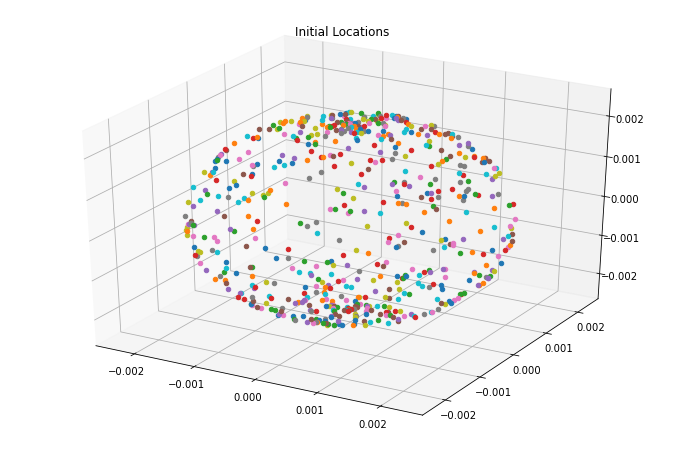

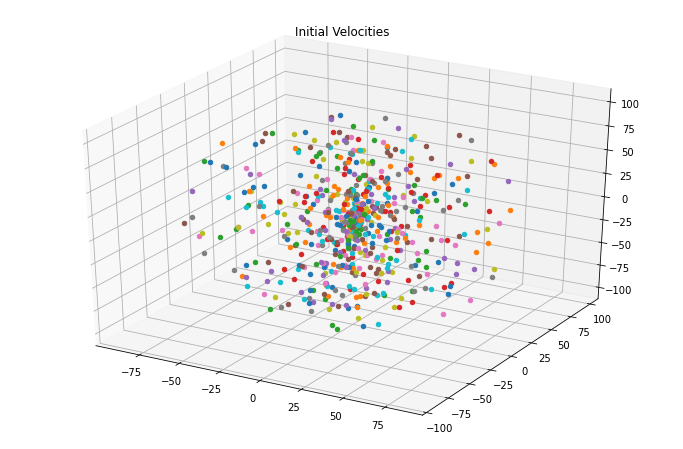

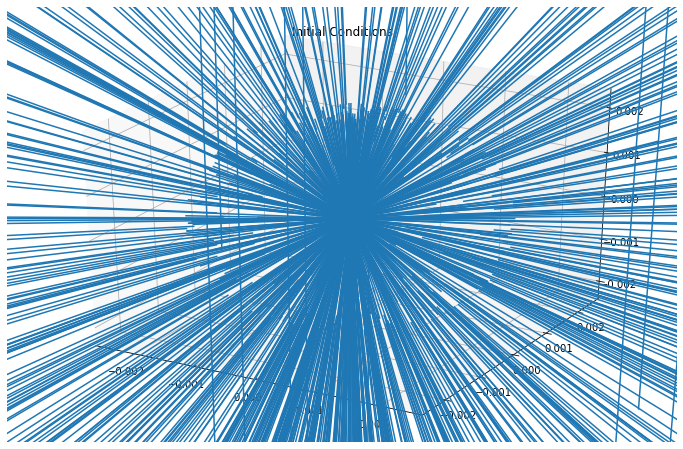

In [13]:
# print (np.asarray(dataDFSph.iloc[3][:-1]))
q = 1
m = 1
dt = 0.01

fig1 = plt.figure(figsize = (12,8))
fig2 = plt.figure(figsize = (12,8))
fig3 = plt.figure(figsize = (12,8))

ax1 = fig1.add_subplot(projection='3d')
ax2 = fig2.add_subplot(projection='3d')
ax3 = fig3.add_subplot(projection='3d')

for row in np.arange(0,dataDFSph.shape[0]):
    sphCon = np.asarray(dataDFSph.iloc[int(row)][:-1])
    sphConPos = sphCon[0:3]
    sphConVel = sphCon [3:6]
    carConPos = conditionSph2Car(sphConPos,sphConVel)[0:3]
    carConVel = conditionSph2Car(sphConPos,sphConVel)[3:6]
    ax1.scatter(carConPos[0], carConPos[1], carConPos[2])
    ax2.scatter(carConVel[0], carConVel[1], carConVel[2])
    ax3.quiver(carConPos[0],carConPos[1],carConPos[2], carConVel[0],carConVel[1],carConVel[2])


ax1.set_title('Initial Locations')
ax2.set_title('Initial Velocities')
ax3.set_title('Initial Conditions')
# positions = trajectorySolver(np.asarray(dataDFSph.iloc[3][:-1]),q,m,dt)[0]
# zlocations = positions[2]

print ('Complete')

### Plotly

In [8]:
dataDFCar = sphDF2CarDF(dataDFSph)

x,y,z = dataDFCar.x,dataDFCar.y,dataDFCar.z
loss = dataDFCar.L
vx,vy,vz = dataDFCar.vx,dataDFCar.vy,dataDFCar.vz

trace1 = go.Scatter3d(
    x=x,
    y=y,
    z=z,
    mode = 'markers',
    marker=dict(
        size=2,
        color = z,
        colorscale='Viridis'
    )
)


trace2 = go.Scatter3d(
    x=vx,
    y=vy,
    z=vz,
    mode = 'markers',
    marker=dict(
        size=2,
        color = z,
        colorscale='Viridis'
    )
)

data1 = [trace1]
fig1 = go.Figure(data=data1)
offline.iplot(fig1, filename='simple-3d-scatter')

data2 = [trace2]
fig2 = go.Figure(data=data2)
offline.iplot(fig2, filename='simple-3d-scatter')



### Minimize Loss

Grab initial condition that has the smallest Loss, compute another set of initial conditions centered around that one.

We arbitrarily choose 1% of a full sphere for both theta and phi.

$\Delta\theta = 0.01\left(\int \sin(\theta) d\theta \right) = 0.01 (2) $\
$\Delta\phi = 0.01 \left( \int d\phi\right) = 0.01 (2\pi)$

As long as $\theta \sim 0$, it will hit the Earth regardless of $\phi$, so we care more about bounding the polar angle.

In [9]:
lossList  = np.abs(dataDFSph.L)
lossLimit = min(lossList)

dataDFSph1 = dataDFSph.loc[ (np.abs(dataDFSph['L']) <=  lossLimit)]

theta = dataDFSph1.theta
phi   = dataDFSph1.phi

margin = 0.01
deltaTheta = margin*2/2
deltaPhi   = margin*2*np.pi/2

columns = ['r','theta','phi','vr','vTheta','vPhi','L']
dataDFSph2 = pd.DataFrame(columns=columns)

# def makeIC(dataDFSph,r,theta,phi,vMin,vMax,numLocs,numVels)
for vr in vels:
    v1 = [vr,0,0]
    for i in positionRange:
        randTheta = float(np.random.uniform(theta-deltaTheta,theta+deltaTheta))
        randPhi   = float(np.random.uniform(phi-deltaPhi,phi+deltaPhi))
        p1 = [rHalf,randTheta,randPhi]

        initialCondition = np.concatenate((p1,v1))
        
        r      = p1[0]
        theta  = p1[1]
        phi    = p1[2]
        vr     = v1[0]
        vtheta = v1[1]
        vphi   = v1[2]

        appendThis = ({'r':r,'theta':theta,'phi':phi,'vr':vr,'vTheta':vtheta,'vPhi':vphi,'L':0,'cosBeta':0})
        dataDFSph2 = dataDFSph2.append(appendThis,ignore_index=True)

dataDFSph2 = computeLossAndBeta(dataDFSph2,q,m,dt)

print ('Complete')

Complete


### Plot New Conditions

In [10]:
dataDFCar2 = sphDF2CarDF(dataDFSph2)

x,y,z = dataDFCar2.x,dataDFCar2.y,dataDFCar2.z
loss  = dataDFCar2.L
vx,vy,vz = dataDFCar2.vx,dataDFCar2.vy,dataDFCar2.vz

trace1 = go.Scatter3d(
    x=x,
    y=y,
    z=z,
    mode = 'markers',
    marker=dict(
        size=2,
        color = z,
        colorscale='Viridis'
    )
)


trace2 = go.Scatter3d(
    x=vx,
    y=vy,
    z=vz,
    mode = 'markers',
    marker=dict(
        size=2,
        color = vz,
        colorscale='Viridis'
    )
)

data1 = [trace1]
fig1 = go.Figure(data=data1)
offline.iplot(fig1, filename='simple-3d-scatter')

data2 = [trace2]
fig2 = go.Figure(data=data2)
offline.iplot(fig2, filename='simple-3d-scatter')


## Evolving the new trajectories that hit Earth

 Generate a new dataframe with initial conditions "centered" on $(r,\theta,\phi) = (r_{half},0,0)$ with spread $(0,\Delta \theta, \Delta \theta)$

In [15]:
deltaTheta = max(dataDFSph2.theta) - min(dataDFSph2.theta)
deltaPhi   = max(dataDFSph2.phi) - min(dataDFSph2.phi)


velNum       = 25 # Number of velocities between vSlow and vFast
numPositions = 25

vSlow = 1
vFast = 99
vels  = np.linspace(vSlow,vFast,velNum)
rHalf = 0.5*0.00465047
positionRange = np.arange(0,numPositions)


columns = ['r','theta','phi','vr','vTheta','vPhi','L','cosBeta']
dataDFSph3 = pd.DataFrame(columns=columns)

# print (random())

for vr in vels:
    v1 = [vr,0,0]

    for i in positionRange:
        
        randPhi = random()*deltaTheta 
        randTheta = random()*deltaTheta
        
        p1 = [rHalf,randTheta,randPhi]

        initialCondition = np.concatenate((p1,v1))
        
        r      = p1[0]
        theta  = p1[1]
        phi    = p1[2]
        vr     = v1[0]
        vtheta = v1[1]
        vphi   = v1[2]

        appendThis = ({'r':r,'theta':theta,'phi':phi,'vr':vr,'vTheta':vtheta,'vPhi':vphi,'L':0,'cosBeta':0})
        dataDFSph3 = dataDFSph3.append(appendThis,ignore_index=True)

print ('{0} Initial Conditions'.format(dataDFSph3.shape[0]))
# print (np.asarray(dataDF.iloc[0][:-1]))
print (dataDFSph3.head(5))
print ('Complete')

625 Initial Conditions
          r     theta       phi   vr  vTheta  vPhi    L  cosBeta
0  0.002325  0.147464  0.022249  1.0     0.0   0.0  0.0      0.0
1  0.002325  0.188259  0.044982  1.0     0.0   0.0  0.0      0.0
2  0.002325  0.114273  0.155542  1.0     0.0   0.0  0.0      0.0
3  0.002325  0.163721  0.101533  1.0     0.0   0.0  0.0      0.0
4  0.002325  0.192219  0.082160  1.0     0.0   0.0  0.0      0.0
Complete


In [16]:
dataDFSph3 = computeLossAndBeta(dataDFSph3,q,m,dt)

In [17]:
dataDFCar = sphDF2CarDF(dataDFSph3)

x,y,z = dataDFCar.x,dataDFCar.y,dataDFCar.z
loss = dataDFCar.L
vx,vy,vz = dataDFCar.vx,dataDFCar.vy,dataDFCar.vz

trace1 = go.Scatter3d(
    x=x,
    y=y,
    z=z,
    mode = 'markers',
    marker=dict(
        size=2,
        color = z,
        colorscale='Viridis'
    )
)


trace2 = go.Scatter3d(
    x=vx,
    y=vy,
    z=vz,
    mode = 'markers',
    marker=dict(
        size=2,
        color = vz,
        colorscale='Viridis'
    )
)

data1 = [trace1]
fig1 = go.Figure(data=data1)
offline.iplot(fig1, filename='simple-3d-scatter')

data2 = [trace2]
fig2 = go.Figure(data=data2)
offline.iplot(fig2, filename='simple-3d-scatter')



## Plot the trajectories

In [20]:
help (conditionSph2Car)

Help on function conditionSph2Car in module __main__:

conditionSph2Car(sphCon, row)
    vel and pos are in spherical coordinates



In [23]:
import plotly.express as px

q,m,dt= 1,1,0.01
xs,ys = [],[]
for row in np.arange(0,dataDFSph3.shape[0]):
    ICSph = np.asarray(dataDFSph3.iloc[row][:-2])
    ICCar = conditionSph2Car(ICSph[0:6],row)
    output = trajectorySolver(ICCar,q,m,dt)
    positions = output[0]
    x,y,z = positions[0],positions[1],positions[2]
    r1 = [x[-1],y[-1],z[-1]]
    r2 = [x[-2],y[-2],z[-2]]
    rAVG = posAvg(r1,r2)
    xs.append(rAVG[0])
#     ys.append(rAVG[1])
    ys.append(rAVG[1])

fig = px.scatter(x=xs,y=ys,color = dataDFSph3.vr, color_continuous_scale=px.colors.sequential.Viridis)
fig.show()

Current dt:  0.01
Current dt:  0.01
Current dt:  0.01
Current dt:  0.01
Current dt:  0.01
Current dt:  0.01
Current dt:  0.01
Current dt:  0.01
Current dt:  0.01
Current dt:  0.01
Current dt:  0.01
Current dt:  0.01
Current dt:  0.01
Current dt:  0.01
Current dt:  0.01
Current dt:  0.01
Current dt:  0.01
Current dt:  0.01
Current dt:  0.01
Current dt:  0.01
Current dt:  0.01
Current dt:  0.01
Current dt:  0.01
Current dt:  0.01
Current dt:  0.01
Current dt:  0.01
Current dt:  0.01
Current dt:  0.01
Current dt:  0.01
Current dt:  0.01
Current dt:  0.01
Current dt:  0.01
Current dt:  0.01
Current dt:  0.01
Current dt:  0.01
Current dt:  0.01
Current dt:  0.01
Current dt:  0.01
Current dt:  0.01
Current dt:  0.01
Current dt:  0.01
Current dt:  0.01
Current dt:  0.01
Current dt:  0.01
Current dt:  0.01
Current dt:  0.01
Current dt:  0.01
Current dt:  0.01
Current dt:  0.01
Current dt:  0.01
Current dt:  0.01
Current dt:  0.01
Current dt:  0.01
Current dt:  0.01
Current dt:  0.01
Current dt

Current dt:  0.01
Current dt:  0.01
Current dt:  0.01
Current dt:  0.01
Current dt:  0.01
Current dt:  0.01
Current dt:  0.01
Current dt:  0.01
Current dt:  0.01
Current dt:  0.01
Current dt:  0.01
Current dt:  0.01
Current dt:  0.01
Current dt:  0.01
Current dt:  0.01
Current dt:  0.01
Current dt:  0.01
Current dt:  0.01
Current dt:  0.01
Current dt:  0.01
Current dt:  0.01
Current dt:  0.01
Current dt:  0.01
Current dt:  0.01
Current dt:  0.01
Current dt:  0.01
Current dt:  0.01
Current dt:  0.01
Current dt:  0.01
Current dt:  0.01
Current dt:  0.01
Current dt:  0.01
Current dt:  0.01
Current dt:  0.01
Current dt:  0.01
Current dt:  0.01
Current dt:  0.01
Current dt:  0.01
Current dt:  0.01
Current dt:  0.01
Current dt:  0.01
Current dt:  0.01
Current dt:  0.01
Current dt:  0.01
Current dt:  0.01
Current dt:  0.01
Current dt:  0.01
Current dt:  0.01
Current dt:  0.01
Current dt:  0.01
Current dt:  0.01
Current dt:  0.01
Current dt:  0.01
Current dt:  0.01
Current dt:  0.01
Current dt

Current dt:  0.01
Current dt:  0.01
Current dt:  0.01
Current dt:  0.01
Current dt:  0.01
Current dt:  0.01
Current dt:  0.01
Current dt:  0.01
Current dt:  0.01
Current dt:  0.01
Current dt:  0.01
Current dt:  0.01
Current dt:  0.01
Current dt:  0.01
Current dt:  0.01
Current dt:  0.01
Current dt:  0.01
Current dt:  0.01
Current dt:  0.01
Current dt:  0.01
Current dt:  0.01
Current dt:  0.01
Current dt:  0.01
Current dt:  0.01
Current dt:  0.01
Current dt:  0.01
Current dt:  0.01
Current dt:  0.01
Current dt:  0.01
Current dt:  0.01
Current dt:  0.01
Current dt:  0.01
Current dt:  0.01
Current dt:  0.01
Current dt:  0.01
Current dt:  0.01
Current dt:  0.01
Current dt:  0.01
Current dt:  0.01
Current dt:  0.01
Current dt:  0.01
Current dt:  0.01
Current dt:  0.01
Current dt:  0.01
Current dt:  0.01
Current dt:  0.01
Current dt:  0.01
Current dt:  0.01
Current dt:  0.01
Current dt:  0.01
Current dt:  0.01
Current dt:  0.01
Current dt:  0.01
Current dt:  0.01
Current dt:  0.01
Current dt

Hot colors represent more energetic particles

# dt Optimization Algorithm

### Old Background and Algorithm

The goal of this section is to optimize the resolution for our trajectory $dt$. In principle, if $dt$ is too large, we won't capture all the "curvature" of the path which will affect the ending angle.

**Considerations**

1. If dt is too large, the neutrino moves faster than the speed of light. Nonphysical.

1. If dt is too small, the computation takes incredibly long. 

1. Arbitrarily choose 5% as our error

**Algorithm**

1. Pick a starting `dt` intentionally too large. I think this should correspond to the `dt` that yields the correct `lightTime`. This won't work. Instead, try to guess a reasonable dt that might be correct. Through trial and error, we find that `dt = 0.0005` is a reasonable starting point.

1. Compute time of flight

1. Decrement `dt` by 20%.

1. Compute time of flight

1. Compare the change in the time of flight to 5%

    a. If < 5%, done. "True" trajectory achieved
    
    b. If > 5%, Decrement `dt` and repeat the process


**Conclusions**

1. Intuitively, as we decrease `dt`, the time of flight should asymptotically approach some "correct" value, corresponding to the "true" trajectory. We believe this approach is always from below, meaning the that if `dt` is too large, the time of flight is too small, and as we decrease `dt` the time of flight asymptotically approaches the actual value.

1. Use the condtion that `TOF[current]`/ `TOF[previous]` < 1.05. The change between the current and previous time of flight should be less than a 5% **increase**. In other words, if we iterate again, we gain less than a 5% increase in the accuracy of the trajectory. 

### Time of Flight and dt

We want to ensure that the trajectory of our neutrinos is independent of the resolution in time $dt$. We do this by plotting the time of flight for masses $ m \in \{1,10,100\}$MeV and $dt \in \{10,1,0.1,0.01,0.001,0.0001,0.00001\}$Au/c. In practice, we don't plot $dt = 10$ because it is unphysical with a time of flight of approx 84 minutes.

In [24]:
r0 = [rDot/2,0,0] # We require that one of x0 or y0 is nonzero
v0 = [1,0,0]
q  = 1 

IC = np.concatenate((r0,v0))

dtRange = [10,1,0.1,0.01,0.001,0.0001,0.00001] # in au/c
mRange  = [1,10,100]

tofM1 = []
tofM10 = []
tofM100 = []

for m in mRange:
    for dt in dtRange:
        IC = np.concatenate((r0,v0))
        output = trajectorySolver(IC,q,m,dt)
        trajectory = output[0]
        timeOfFlight = auOverc2min(dt)*len(trajectory[0])
        
        if m == 1:
            tofM1.append(timeOfFlight)
        if m == 10:
            tofM10.append(timeOfFlight)
        if m == 100:
            tofM100.append(timeOfFlight)
    
        print (m,dt,": Finished")
            
print ('Complete')

Current dt:  10
1 10 : Finished
Current dt:  1
1 1 : Finished
1 0.1 : Finished
1 0.01 : Finished
1 0.001 : Finished
1 0.0001 : Finished
1 1e-05 : Finished
Current dt:  10
10 10 : Finished
Current dt:  1
10 1 : Finished
10 0.1 : Finished
10 0.01 : Finished
10 0.001 : Finished
10 0.0001 : Finished
10 1e-05 : Finished
Current dt:  10
100 10 : Finished
Current dt:  1
100 1 : Finished
100 0.1 : Finished
100 0.01 : Finished
100 0.001 : Finished
100 0.0001 : Finished
100 1e-05 : Finished
Complete


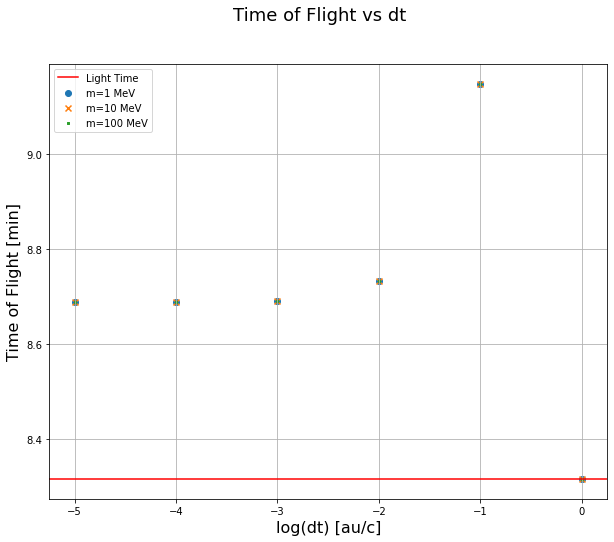

In [25]:
fig = plt.figure(figsize = (10,8))
plt.scatter(np.log10(dtRange[1:]),(tofM1[1:]),label = 'm=1 MeV',marker = 'o')
plt.scatter(np.log10(dtRange[1:]),(tofM10[1:]),label = 'm=10 MeV',marker = 'x')
plt.scatter(np.log10(dtRange[1:]),(tofM100[1:]),label = 'm=100 MeV',marker = 's',s = 3)
plt.axhline(y=auOverc2min(1), color='r', linestyle='-', label = 'Light Time')
plt.xlabel('log(dt) [au/c]', size = 16)
plt.ylabel('Time of Flight [min]', size = 16)
plt.legend(loc = 'upper left')
plt.suptitle('Time of Flight vs dt', size = 18)
plt.grid()
plt.show()

### Trajectory as a function of dt

In [28]:
dict1 = {
#     '10':None,
    '1':[],
    '0.1':[],
#     '0.01':[],
#     '0.001':None,
    '0.0001':[],
#     '0.00001':None
}

r0 = [rDot/2,0,0] # We require that one of x0 or y0 is nonzero
v0 = [1,0,0]
q  = 1 
m  = 1
IC = np.concatenate((r0,v0))

for key in dict1.keys():
    IC = np.concatenate((r0,v0))
    dt =(float(key))
    trajectory = trajectorySolver(IC,q,m,dt)
    dict1[key] = trajectory[0]
    

Current dt:  1.0


In [31]:
columns = ['x','y','z']
df = pd.DataFrame.from_dict(dict1, orient='index', columns = columns)
dtList = [0.1,0.01,0.0001]
df['dt'] = dtList
# print (df)
# print (df.shape)

x1,y1,z1 = df.iloc[0]['x'],df.iloc[0]['y'],df.iloc[0]['z']
x2,y2,z2 = df.iloc[1]['x'],df.iloc[1]['y'],df.iloc[1]['z']
x3,y3,z3 = df.iloc[2]['x'],df.iloc[2]['y'],df.iloc[2]['z']

# fig = px.scatter_3d(df, x='x', y='y', z='z',color = 'dt')
# fig.show()

trace1 = go.Scatter3d(
    x=x1,
    y=y1,
    z=z1,
    mode = 'markers',
    marker=dict(
        size=5,
        color = 'red',
        colorscale='Viridis'
    )
)

trace2 = go.Scatter3d(
    x=x2,
    y=y2,
    z=z2,
    mode = 'markers',
    marker=dict(
        size=3,
        color = 'blue',
        colorscale='Viridis'
    )
)

trace3 = go.Scatter3d(
    x=x3,
    y=y3,
    z=z3,
    mode = 'markers',
    marker=dict(
        size=1,
        color = 'green',
        colorscale='Viridis'
    )
)
data1 = [trace1]
fig1 = go.Figure(data=data1)
fig1.add_trace(trace2)
fig1.add_trace(trace3)
offline.iplot(fig1, filename='simple-3d-scatter')


In practice, we choose $dt=0.01$ au/c because it yields an accurate time of flight for a particle traveling at the speed of light. Any larger dt up to 1 au/c also yields an accurate time of flight, but we lose resolution with may affect the ending angle $\beta$. If we choose a dt smaller than 0.01 au/c, we see that the particle travels faster than light, which is unphysical. It is unclear why this happens, but for these 5 minutes, we ignore this and continue on with dt = 0.01 au/c.

### Beta and dt

In [32]:
r0 = [rDot/2,0,0] # We require that one of x0 or y0 is nonzero
v0 = [1,0,0]
q  = 1 

IC = np.concatenate((r0,v0))

dtRange = [0.1,0.01,0.001,0.0001,0.00001] # in au/c
mRange  = [1,10,100]

betaM1 = []
betaM10 = []
betaM100 = []
for m in mRange:
    for dt in dtRange:
        IC = np.concatenate((r0,v0))
        output = trajectorySolver(IC,q,m,dt)
        beta = endingAngle(output)
        
        if m == 1:
            betaM1.append(beta)
        if m == 10:
            betaM10.append(beta)
        if m == 100:
            betaM100.append(beta)
    
        print (m,dt,": Finished")
            
print ('Complete')

1 0.1 : Finished
1 0.01 : Finished
1 0.001 : Finished
1 0.0001 : Finished
1 1e-05 : Finished
10 0.1 : Finished
10 0.01 : Finished
10 0.001 : Finished
10 0.0001 : Finished
10 1e-05 : Finished
100 0.1 : Finished
100 0.01 : Finished
100 0.001 : Finished
100 0.0001 : Finished
100 1e-05 : Finished
Complete


In [44]:
print (dtRange)
print (betaM1)

[0.1, 0.01, 0.001, 0.0001, 1e-05]
[0.8887227240201766, 0.8684830828485165, 0.8663694403126578, 0.8660571527780154, 0.8660284044600466]


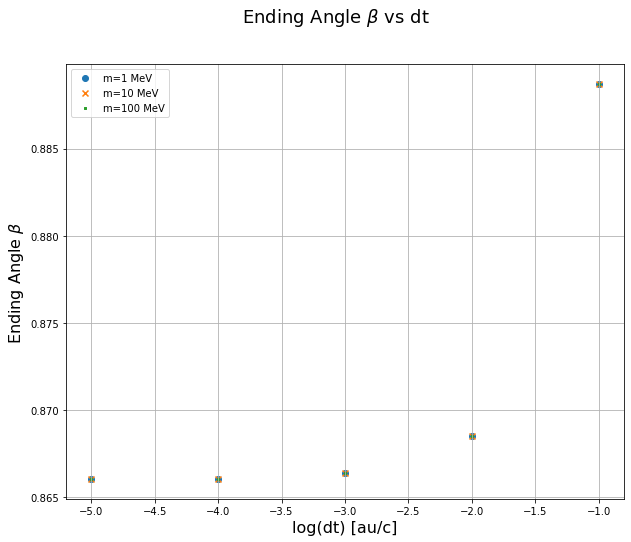

In [49]:
fig = plt.figure(figsize = (10,8))
plt.scatter(np.log10(dtRange),(betaM1),label = 'm=1 MeV',marker = 'o')
plt.scatter(np.log10(dtRange),(betaM10),label = 'm=10 MeV',marker = 'x')
plt.scatter(np.log10(dtRange),(betaM100),label = 'm=100 MeV',marker = 's',s = 3)
# plt.axhline(y=auOverc2min(1), color='r', linestyle='-', label = 'Light Time')
plt.xlabel('log(dt) [au/c]', size = 16)
plt.ylabel(r'Ending Angle $\beta$', size = 16)
plt.legend(loc = 'upper left')
plt.suptitle(r'Ending Angle $\beta$ vs dt', size = 18)
# plt.ylim(0.98,1.02)
plt.grid()
plt.show()

### Time of Flight vs Field Strength